# Ridge-PCA analysis for MPFC Data

```
By: Jake M. Parelman
Final Edit: 06/30/2021
```

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import preprocessing

import pandas as pd 
import numpy as np
import pickle
import random 
import glob

from nilearn import plotting, image, input_data

import matplotlib.pyplot as plt

%matplotlib inline

from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr

/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


### Load Data

In [4]:
X_train = np.load('../Data/mpfc_training_X.npy')
y_train = np.load('../Data/mpfc_training_y.npy')

X_test = np.load('../Data/mpfc_testing_X.npy')
y_test = np.load('../Data/mpfc_testing_y.npy')

### PCA

In [5]:
mpfc_pca = PCA()

In [6]:
# Scale data
X_train_mc = preprocessing.StandardScaler().fit_transform(X_train)
X_test_mc = preprocessing.StandardScaler().fit_transform(X_test)

# Fit PCA
X_train = mpfc_pca.fit_transform(X_train)
X_test = mpfc_pca.transform(X_test)

### Model Tuning and Training

In [7]:
# cross validation and scoring
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=5)
scoring = {'Accuracy': make_scorer(accuracy_score)}

# Ridge setup
ridge_ = GridSearchCV(estimator=LogisticRegression(penalty='l2',solver='liblinear'),
                     cv=skfold,
                     scoring=scoring,
                     n_jobs=1,
                     param_grid=dict(C=np.arange(0.0001,1,0.1)),
                               return_train_score=False,
                           refit='Accuracy')

# Tuning
ridge_.fit(X_train,y_train)
ridge_hyper = ridge_.best_params_['C'] # best hyperparam

In [8]:
CV_df = pd.DataFrame(ridge_.cv_results_)
CV_df.loc[ridge_.best_index_]
CV_df.loc[ridge_.best_index_,]

mean_fit_time                0.109535
std_fit_time                 0.026173
mean_score_time              0.002891
std_score_time               0.002834
param_C                        0.0001
params                  {'C': 0.0001}
split0_test_Accuracy         0.672489
split1_test_Accuracy         0.576419
split2_test_Accuracy         0.624454
split3_test_Accuracy         0.676856
split4_test_Accuracy         0.676856
mean_test_Accuracy           0.645415
std_test_Accuracy            0.039774
rank_test_Accuracy                  1
Name: 0, dtype: object

### Permutation Procedures

In [9]:
# Functions for permutations
k = 1000

def permute(x,classifier):
    if x % 100 == 0:
        print("*",end="")
    yy = y_train.copy()
    np.random.shuffle(yy)    

    classifier.fit(X_train,yy)
    # Back project model weights
    orig_features = np.dot(mpfc_pca.components_.T,classifier.coef_[0])
    return orig_features
    
def test_perms(x):
    """
    calculate p_value
    """
    perm_list = np.abs(x[:-1])
    model_val = np.abs(x[-1]) # last row is true model
    greater_equal = [i for i in perm_list if i >= model_val]
    return len(greater_equal)/len(perm_list)

In [10]:
# run permutations
ridge_perm_classifier = LogisticRegression(penalty='l2',
                                solver='liblinear',
                                C=ridge_hyper
                               )

# Run permutation
Perms = []
for x in range(k):
    Perms.append(permute(x, ridge_perm_classifier))

# last row true model
Perms.append(np.dot(mpfc_pca.components_.T,ridge_.best_estimator_.coef_[0]))

**********

### Plot Maps

In [11]:
# get p-values and FDR correction
Perms = np.array(Perms)
sigs = np.apply_along_axis(arr=Perms,func1d=test_perms,axis=0)
a,p_fdr,_,_ = multipletests(pvals=sigs,method='fdr_bh',alpha=0.05)

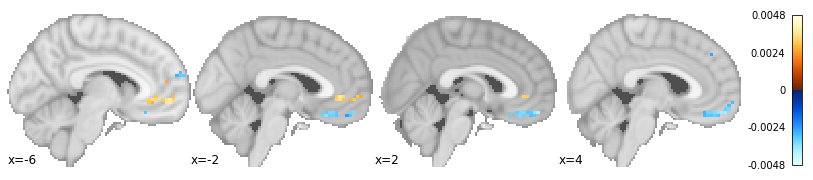

In [14]:
# plotting
mpfc_mask = image.load_img('Data/ROI/mPFC_resampled.nii')
mpfc_masker = input_data.NiftiMasker(mask_img=mpfc_mask)
mpfc_masker.fit_transform(mpfc_mask)

Mapped = np.copy(Perms[-1,:])
Mapped[np.where(p_fdr >= 0.05)] = 0

threshed_map = mpfc_masker.inverse_transform(Mapped)

plotting.plot_stat_map(
    threshed_map, colorbar=True,draw_cross=False,
    display_mode='x',cut_coords=[-6,-2,2,4],cmap='cyan_orange')

In [15]:
threshed_map.to_filename('Data/MPFC_Ridge_threshed.nii')

### Bootstrap Out of Sample Testing

In [14]:
T = 500
boots = []

for i in range(T):
    # Bootstrap Sample
    ix,y = zip(*[random.choice(list(enumerate(y_test))) for i in range(len(y_test))])
    X = X_test[ix,:]

    # Test Accuracy
    accuracy = np.sum(y == ridge_.predict(X))/len(y) 
    boots.append(accuracy)
    
# Print bootstrap mean accuracy and CI
alpha = 0.95
lower = np.round(100*max(0.0, np.percentile(boots, 2.5)),2)
upper = np.round(100*min(1.0, np.percentile(boots, 97.5)),2)
acc = np.round(np.mean(boots) *100,2)
print(f"Test Accuracy = {acc}, [{lower},{upper}], std = {np.std(boots)}")

Test Accuracy = 59.15, [53.33,64.67], std = 0.027089050678579838


### Testing Gradient

In [12]:
def get_std_coords(vals,coefs):
    mpfc_x_coords = vals[0]
    nmin = np.min(mpfc_x_coords)
    nmax = np.max(mpfc_x_coords)
    std_x_coords = [((val - nmin)/(nmax - nmin)) for val in mpfc_x_coords]

    mpfc_y_coords = vals[1]
    nmin = np.min(mpfc_y_coords)
    nmax = np.max(mpfc_y_coords)
    std_y_coords = [((val - nmin)/(nmax - nmin)) for val in mpfc_y_coords]
    
    mpfc_z_coords = vals[2]
    nmin = np.min(mpfc_z_coords)
    nmax = np.max(mpfc_z_coords)
    std_z_coords = [((val - nmin)/(nmax - nmin)) for val in mpfc_z_coords]

    return pd.DataFrame({
        "Weight":coefs,
        "x":std_x_coords,
        "y":std_y_coords,
        "z":std_z_coords
    })
    

In [54]:
cor_perms = []
ix = 0
for p in Perms:
    ix += 1
    if ix % 10 == 0:
        print('*',end='')
    unthreshed = mpfc_masker.inverse_transform(p)
    z_coefs = mpfc_masker.fit_transform(unthreshed)[0]
    z_3d = np.array(np.where(unthreshed.get_data() != 0))
    z_df = get_std_coords(z_3d,z_coefs)
    cor_perms.append(pearsonr(z_df['Weight'],z_df['z'])[0])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':


****************************************************************************************************

In [55]:
i = 0
for p in cor_perms[:-1]:
    if -1*p >= -1*cor_perms[-1]:
        i += 1

print(f"Pearson R: {cor_perms[-1]}, p = {1 + i/len(cor_perms)-1}")

Pearson R: -0.08800480045486632, p = 0.03996003996003994


In [2]:
# Save z-coordinate mapping
unthreshed = mpfc_masker.inverse_transform(Perms[-1,:])
z_coefs = mpfc_masker.fit_transform(unthreshed)[0]
z_3d = np.array(np.where(unthreshed.get_data() != 0))
z_df = get_std_coords(z_3d,z_coefs)
z_df.to_csv('Data/mpfc_weights_RidgePCA_xyz.csv')